In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
import sys
sys.path.append("/g/g92/dskoda/prj/dskrc/python/inits")

from plotting import *
plt.rcParams['figure.dpi'] = 150

In [3]:
MACE_LABELS = {
    'baseline': "no_rescaling",
    'non_trainable_bessel': "no_bessel",
    'non_trainable_bessel_no_amsgrad_no_ema_no_swa_wc': "only_rescaling",
    'rescaling': "rescaling+bessel",
    'v1_l0': 'v1_l0',
    'v1_l3': 'v1_l3',
    'v2_l0': 'v2_l0',
    'v2_l1': 'v2_l1',
    'v2_l2': 'v2_l2',
    'v2_l3': 'v2_l3',
    'v3_l3': 'v3_l3',
    'v2_l3_yes_rescaling_no_amsgrad_no_ema_no_swa_wc': "v2-base",
    'v2_l3_yes_rescaling_no_amsgrad_no_ema_yes_swa_wc': "v2-swa",
    'v2_l3_yes_rescaling_no_amsgrad_yes_ema_no_swa_wc': "v2-ema",
    'v2_l3_yes_rescaling_yes_amsgrad_no_ema_no_swa_wc': "v2-amsgrad",
}

LEARNING_CURVES_LABELS = {
    'v=2, L=3, baseline': "v2-base",
    'v=2, L=3, AMSGrad-only': "v2-amsgrad",
    'v=2, L=3, EMA-only': "v2-ema",
    'v=2, L=3, SWA+WC-only': "v2-swa",
    'v=3, L=3': "v3_l3",
    'v=2, L=3': "v2_l3",
    'v=1, L=3': "v1_l3",
    'v=2, L=2': "v2_l2",
    'v=2, L=1': "v2_l1",
    'v=2, L=0': "v2_l0",
    'v=1, L=0': "v1_l0",
}

MODELS_1 = ["no_rescaling", "no_bessel", "only_rescaling", "rescaling+bessel"]
MODELS_2 = [
   'v2-base',
   'v2-swa',
   'v2-ema',
   'v2-amsgrad'
]
MODELS_3 = ['v2_l0', 'v2_l1', 'v2_l2', 'v2_l3'] 
MODELS_4 = ['v1_l3', 'v2_l3', 'v3_l3']
MODELS_5 = ["v1_l0", "v2_l0"]

MODELS_L3 = MODELS_1 + MODELS_2 + MODELS_4

MODELS_ORDER = MODELS_1 + MODELS_2 + MODELS_3 + MODELS_4 + MODELS_5

## Loading the model parameters

In [4]:
BASE_PATH = "/usr/workspace/dsk-jv/trained_models/mace"

models = sorted(os.listdir(BASE_PATH))

In [5]:
def str_to_dict(string):
    items = re.split(',(?![^{]*\})', string)
    dictionary = {}
    for item in items:
        key, value = item.split('=')
        key = key.strip()
        value = value.strip("\'")
        value = value.strip('"')
        try:
            value = int(value)
        except ValueError:
            try:
                value = float(value)
            except ValueError:
                if value.lower() == 'true':
                    value = True
                elif value.lower() == 'false':
                    value = False
                else:
                    value = value
        dictionary[key] = value
    return dictionary

In [6]:
_results = {}

x = np.linspace(-0.25, 0.25, 81)
for model in models:
    files = os.listdir(os.path.join(BASE_PATH, model, "logs"))
    if len(files) == 0:
        continue
    
    log = os.path.join(BASE_PATH, model, "logs", files[0])
    with open(log, "r") as f:
        log = f.read()
    
    namespace = re.findall("Namespace\((.*)\)", log)[0]
    _results[model] = str_to_dict(namespace)

cfg = pd.DataFrame(_results)
cfg.columns = [MACE_LABELS.get(c, c) for c in cfg.columns]
cfg = cfg.T
# cfg = cfg[MODELS_1 + MODELS_2 + MODELS_3].fillna(False)

## Loading the learning curves first

In [7]:
with open("/usr/workspace/dsk-jv/trained_models/learning_curves_with_bigtrends_mace.json", "r") as f:
    lcurv = json.load(f)

In [8]:
N = [5, 25, 125, 250, 500]

lc_results = []
for m in ["MACE"]:
    subdict = lcurv[m]["3BPA"]
    for params, curves in subdict.items():
        for row, n in zip(curves, N):
            lc_results.append({
                "model": m,
                "params": MACE_LABELS.get(params, params),
                "n": n,
                "e": row[0],
                "f": row[1],
            })

ldf = pd.DataFrame(lc_results)
ldf["params"] = ldf["params"].apply(lambda x: LEARNING_CURVES_LABELS.get(x, x))

In [9]:
ldf

,model,params,n,e,f
0,MACE,v2-base,5,0.653837,0.370032
1,MACE,v2-base,25,0.004508,0.141119
2,MACE,v2-base,125,0.001354,0.082481
3,MACE,v2-base,250,0.001180,0.077482
4,MACE,v2-base,500,0.001022,0.067232
...,...,...,...,...,...
65,MACE,no_bessel,5,0.009435,0.344038
66,MACE,no_bessel,25,0.003117,0.157473
67,MACE,no_bessel,125,0.001462,0.082145
68,MACE,no_bessel,250,0.001172,0.068898


## Now loading the LLs

In [10]:
BASE_PATH = "/usr/workspace/dsk-jv/trained_models/mace"

models = sorted(os.listdir(BASE_PATH))

In [11]:
results = []

x = np.linspace(-0.25, 0.25, 81)
for model in models:
    forces = np.load(os.path.join(BASE_PATH, model, "forces_rays.npy"))
    energy = np.load(os.path.join(BASE_PATH, model, "energy_rays.npy"))
    
    for _x, _f, _e in zip(x, forces, energy):
        results.append({
            "model": model,
            "x": _x,
            "f": _f,
            "e": _e,
        })

df = pd.DataFrame(results)
df["model"] = df["model"].apply(lambda x: MACE_LABELS.get(x, x))

## Finally, loading the explosion times

In [12]:
exp = pd.read_csv("02_data/mace_explosion.csv", index_col=0)
exp["model"] = exp["model"].apply(lambda x: MACE_LABELS.get(x, x))
exp.to_csv("02_data/mace_explosion.csv")

mexp = exp.groupby("model")["explosion"].mean()
mexp.name = "explosion_mean"

mdexp = exp.groupby("model")["explosion"].median()
mdexp.name = "explosion_med"

sexp = exp.groupby("model")["explosion"].std()
sexp.name = "explosion_std"

iqexp = exp.groupby("model")["explosion"].agg(stats.iqr)
iqexp.name = "explosion_iqr"

all_exp = pd.concat([
    mexp,
    mdexp,
    sexp,
    iqexp,
], axis=1)

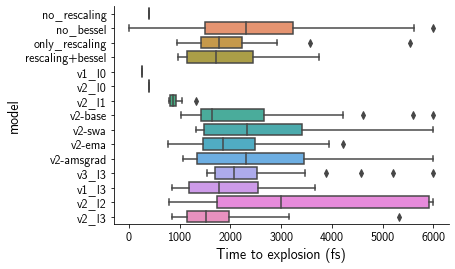

In [13]:
fig, ax = plt.subplots()

sns.boxplot(
    data=exp,
    x="explosion",
    y="model",
    ax=ax,
)

ax.set_xlabel("Time to explosion (fs)")
plt.show()

## Analyzing the loss landscapes

### Calculating metrics on the loss landscape

In [14]:
def get_curvature(x, y):
    def parabola(x, a, b, c):
        return a * x**2 + b * x + c

    A = np.vstack([x**2, x, np.ones(len(x))]).T
    b = y

    params, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

    a, b, c = params

    curvature = 2 * a / ((1 + b**2)**(3/2))

    return curvature

def get_entropy(x, T=1e-2, k=1.0):
    beta = 1 / (k * T)
    Q = np.sum(np.exp(-beta * x))
    return k * np.log(Q)

In [15]:
_sdf = []

T_F = 4e-2
T_E = 4e-3
ALPHA = 0.2
X_THRESHOLD = 0.025

for model, _df in df.groupby("model"):    
    Sf = get_entropy(_df["f"].values, T=T_F)
    Se = get_entropy(_df["e"].values, T=T_E)
    
    _subdf = _df.loc[np.abs(_df.x) < X_THRESHOLD]
    curv_e = get_curvature(_subdf.x, _subdf.e)
    curv_f = get_curvature(_subdf.x, _subdf.f)

    _sdf.append({
        "model": model,
        "Se": Se,
        "Sf": Sf,
        "S": ALPHA * Se + (1 - ALPHA) * Sf,
        "Ce": curv_e,
        "Cf": curv_f,
    })

In [16]:
sdf = pd.DataFrame(_sdf)
sdf = pd.concat([
    sdf.set_index("model"),
    all_exp,
], axis=1)

In [17]:
nldf = ldf.loc[
    (ldf.model == "MACE")
    & (ldf["n"] == 500)
].set_index("params")[["e", "f"]]

In [18]:
# trainable = pd.DataFrame([{
#     '2-layer': 0,
#     '3-layer': 0,
#     '4-layer': 0,
#     '5-layer': 0,
#     '5-layer, AMSGrad-only': 1,
#     '5-layer, EMA-only': 1,
#     '5-layer, baseline': 1,
#     'baseline': 1,
#     'non_trainable_bessel': 0,
#     'rescaling': 1,
# }], index=["trainable"]).T

data = pd.concat([
    sdf,
    nldf,
    cfg["max_ell"],
#     trainable
], axis=1)

In [19]:
data

,Se,Sf,S,Ce,Cf,explosion_mean,explosion_med,explosion_std,explosion_iqr,e,f,max_ell
no_bessel,0.625645,2.479747,2.108926,56.969876,68.001982,2528.666667,2308.0,1399.122664,1747.50,0.001043,0.059764,3
no_rescaling,-0.307666,-0.054471,-0.105110,1.149211,2.677355,392.000000,392.0,0.000000,0.00,0.048415,2.972685,3
only_rescaling,0.282213,2.452588,2.018513,91.287065,78.936933,1944.758621,1774.0,897.675914,815.00,NaN,NaN,3
rescaling+bessel,0.524652,2.528016,2.127343,64.245988,55.775871,1863.366667,1721.5,811.526466,1300.75,0.001229,0.066857,3
v1_l0,1.253392,1.520238,1.466869,30.491225,70.175051,251.000000,251.0,0.000000,0.00,0.003948,0.218790,0
v1_l3,2.036267,2.170322,2.143511,12.809207,49.842531,1921.833333,1769.5,844.513697,1356.50,0.002290,0.123261,3
v2-amsgrad,0.480399,2.483268,2.082695,68.060972,73.148495,2705.833333,2312.5,1505.386560,2116.75,0.000886,0.055017,3
v2-base,0.282213,2.452588,2.018513,91.287065,78.936933,2247.133333,1629.5,1366.572726,1231.75,0.001022,0.067232,3
v2-ema,0.075274,2.449223,1.974433,105.463929,76.952296,2133.600000,1851.0,896.884400,1019.00,0.001395,0.068343,3
v2-swa,0.551182,2.558111,2.156725,61.575697,64.908311,2677.689655,2332.0,1302.624935,1931.00,0.001182,0.068836,3


In [20]:
all_exp.to_csv("02_data/mace_explosion_stats.csv")
ldf.drop("model", axis=1).rename(columns={"params": "model"}).to_csv("02_data/mace_learning.csv")
df.to_csv("02_data/mace_losslands.csv")
cfg.to_csv("02_data/mace_hyperparams.csv")
data.to_csv("02_data/mace_entropy.csv")